In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import os
import IPython.display as ipd 

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split


In [2]:
data = pd.DataFrame(columns = ['Emotion','Emotion_intensity','Actor_no','File'])
for dirname, _, filenames in os.walk('../project/data'):
    for filename in filenames:
        data = data.append({'Emotion':filename[6:8],'Emotion_intensity': filename[9:11], 'Actor_no':filename[-6:-4]
                            ,'File':os.path.join(dirname, filename)}, ignore_index= True)

data.head()

,Emotion,Emotion_intensity,Actor_no,File
0,07,02,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav
1,08,01,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav
2,06,01,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav
3,03,02,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav
4,02,01,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav


In [3]:
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
def convert_labels(x):
    if x == '01':
        return 'neutral'
    elif x == '02':
        return 'calm'
    elif x == '03':
        return 'happy'
    elif x == '04':
        return 'sad'
    elif x == '05':
        return 'angry'
    elif x == '06':
        return 'fearful'
    elif x == '07':
        return 'disgust'
    elif x == '08':
        return 'surprised'
    
def convert_emotion_intensity(x):
    if x == '01':
        return 'Normal'
    elif x == '02':
        return 'Strong'

data['Emotion_intensity'] = data.apply(lambda x: convert_emotion_intensity(x['Emotion_intensity']), axis =1)    
data['Emotion'] = data.apply(lambda x: convert_labels(x['Emotion']), axis = 1)

In [4]:
def gender(x):
    x = int(x)
    if x %2 ==0:
        return 'Female'
    else:
        return 'Male'
    
data['Gender'] = data.apply(lambda x: gender(x['Actor_no']), axis =1)

In [5]:
data.head()

,Emotion,Emotion_intensity,Actor_no,File,Gender
0,disgust,Strong,16,../project/data/Actor_16/03-01-07-02-02-01-16.wav,Female
1,surprised,Normal,16,../project/data/Actor_16/03-01-08-01-02-02-16.wav,Female
2,fearful,Normal,16,../project/data/Actor_16/03-01-06-01-01-02-16.wav,Female
3,happy,Strong,16,../project/data/Actor_16/03-01-03-02-02-01-16.wav,Female
4,calm,Normal,16,../project/data/Actor_16/03-01-02-01-01-01-16.wav,Female


In [6]:
data.Emotion.value_counts()

disgust      384
sad          384
angry        384
happy        384
calm         384
fearful      384
surprised    384
neutral      192
Name: Emotion, dtype: int64

In [7]:
data.Emotion_intensity.value_counts()

Normal    1536
Strong    1344
Name: Emotion_intensity, dtype: int64

In [8]:
data.Gender.value_counts()

Male      1440
Female    1440
Name: Gender, dtype: int64

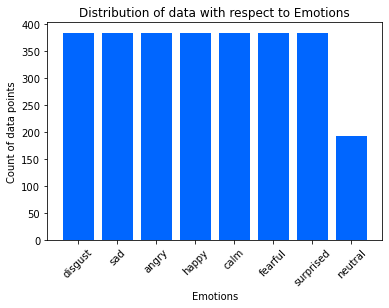

In [31]:
plt_data = pd.DataFrame(data.Emotion.value_counts()).reset_index()
plt_data.columns = ['Emotion', 'value']
plt.bar(plt_data.Emotion, plt_data.value, color = '#0066FF')
plt.xticks(rotation = 45)
plt.xlabel("Emotions")
plt.ylabel("Count of data points")
plt.title("Distribution of data with respect to Emotions")
plt.show()

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential


In [33]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [34]:
fname1=  data.File[0]
audio_data, sr = librosa.load(fname1)
ipd.Audio(fname1) 

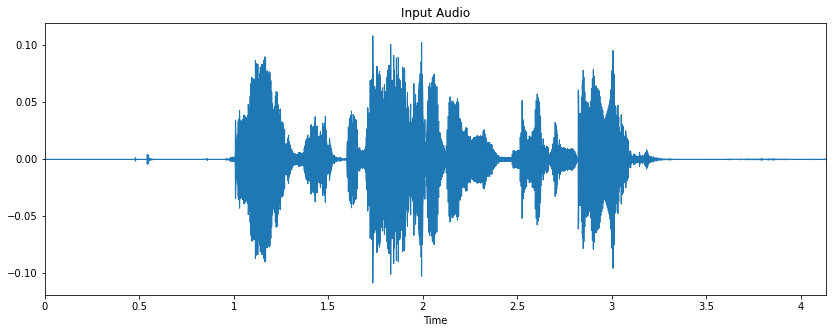

In [37]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio_data, sr=sr)
plt.title("Input Audio")
plt.show()

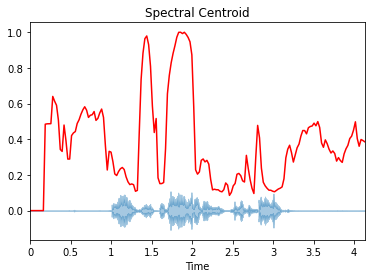

In [49]:
spectral_centroids = librosa.feature.spectral_centroid(audio_data, sr=sr)[0]
import sklearn
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(audio_data, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.title("Spectral Centroid")
plt.show()


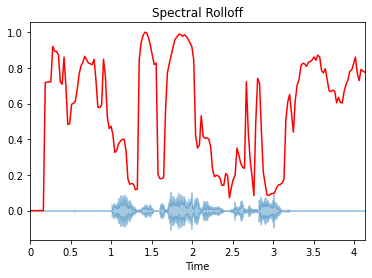

In [50]:
spectral_rolloff = librosa.feature.spectral_rolloff(audio_data, sr=sr)[0]
librosa.display.waveplot(audio_data, sr=sr, alpha=0.4)
plt.title("Spectral Rolloff")
plt.plot(t, normalize(spectral_rolloff), color='r')

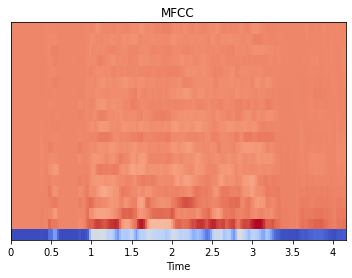

In [60]:
mfccs = librosa.feature.mfcc(audio_data, sr=sr)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.title("MFCC")
plt.show()

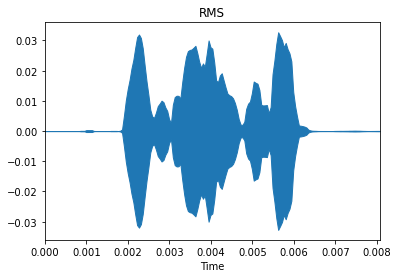

In [62]:
mfccs = librosa.feature.rms(audio_data, sr)[0]
librosa.display.waveplot(mfccs, sr=sr)
plt.title("RMS")
plt.show()

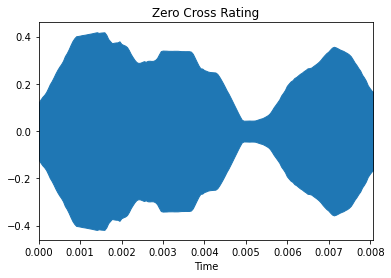

In [64]:
mfccs = librosa.feature.zero_crossing_rate(audio_data, sr)[0]
librosa.display.waveplot(mfccs, sr=sr)
plt.title("Zero Cross Rating")
plt.show()

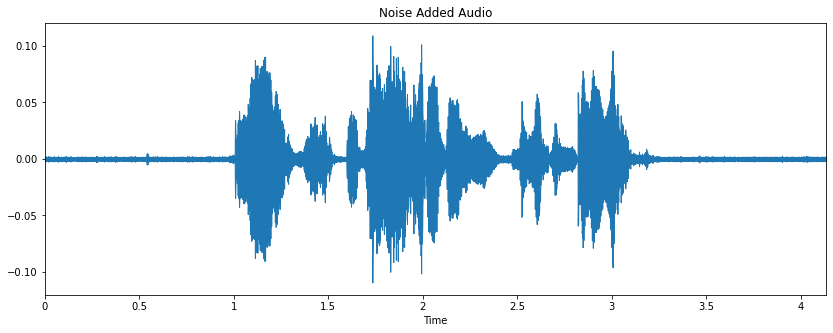

In [65]:
new = noise(audio_data)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(new, sr=sr)
plt.title("Noise Added Audio")
plt.show()

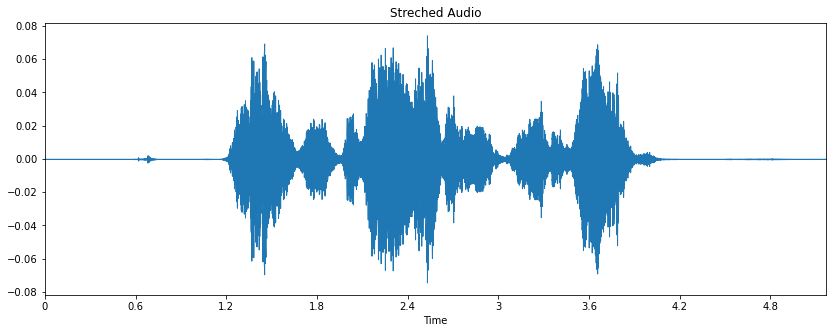

In [66]:
new = stretch(audio_data)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(new, sr=sr)
plt.title("Streched Audio")
plt.show()

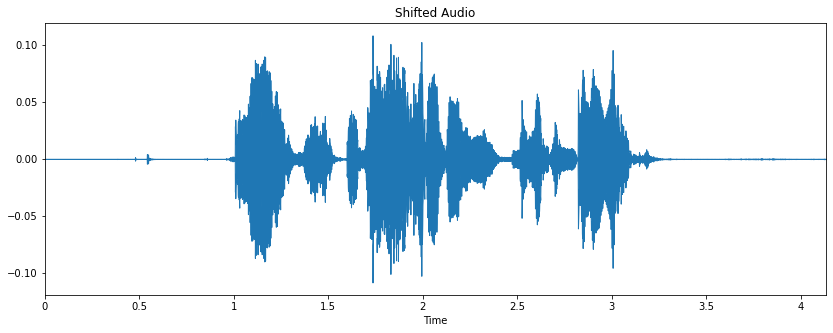

In [67]:
new = shift(audio_data)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(new, sr=sr)
plt.title("Shifted Audio")
plt.show()

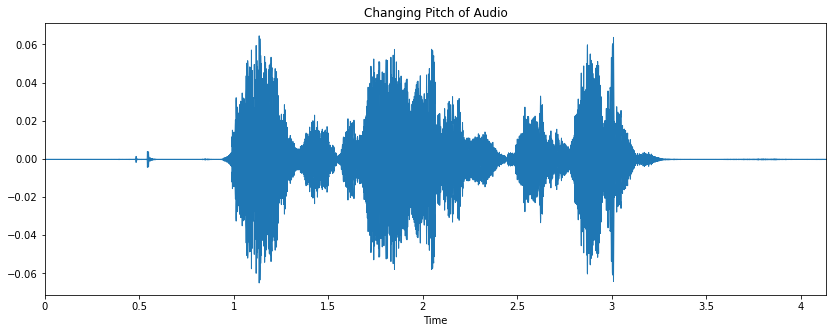

In [68]:
new = pitch(audio_data, sr)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(new, sr=sr)
plt.title("Changing Pitch of Audio")
plt.show()